# Caso Base



## Modelo Matemático: Problema de Ruteo de Vehículos con Capacidad y Autonomía

### **Conjuntos**

-  V : Conjunto de vehículos.
-  N : Conjunto de todos los nodos (depósitos + municipios).
-  P : Conjunto de depósitos.
-  D : Conjunto de municipios (clientes).

### **Parámetros**

- `Ft`: Tarifa de flete por km (COP/km).
- `Cm`: Costo de mantenimiento por km (COP/km).
- `dist_i,j`: Distancia entre el nodo \( i \) y el nodo \( j \) (km).
- ` Q_v `: Capacidad máxima de carga del vehículo \( v \).
- `Autonomy_v`: Autonomía (capacidad de combustible) del vehículo \( v \).
- `demand_j`: Demanda del municipio \( j \).

### **Variables de Decisión**

 $$ x_{v,i,j} \in {0,1}$$ 

  - 1 si el vehículo \( v\)  viaja del nodo  \(i\)  al nodo \( j\) , 0 en caso contrario.
$$  q_{v,j} \ge 0 $$

  - Cantidad entregada por el vehículo \( v \) en el municipio \( j \).



### **Función Objetivo**

Minimizar el costo total de transporte y mantenimiento:

$$\min \sum_{v \in V} \sum_{\substack{i \in N \\ j \in N \\ i \ne j}} \left( \text{Ft} \times \text{dist}_{i,j} + \text{Cm} \times \text{dist}_{i,j} \right) \times x_{v,i,j}$$



### **Restricciones**

1. **Visita Única por Cliente:**

Cada cliente debe ser visitado exactamente una vez:

$$
\sum_{v \in V} \sum_{\substack{i \in N \\ i \ne j}} x_{v,i,j} = 1 \quad \forall j \in D
$$



2. **Conservación de Flujo:**

Para cada vehículo y cada nodo (excepto depósitos), la cantidad que entra debe ser igual a la que sale:

$$
\sum_{\substack{i \in N \\ i \ne k}} x_{v,i,k} = \sum_{\substack{j \in N \\ j \ne k}} x_{v,k,j} \quad \forall v \in V, \forall k \in N
$$



3. **Capacidad del Vehículo:**

El total de carga entregada por cada vehículo no puede superar su capacidad:

$$
\sum_{j \in D} q_{v,j} \le Q_v \quad \forall v \in V
$$



4. **Entrega de Demanda Condicionada a Visita:**

La cantidad entregada en un municipio solo puede ser positiva si se visita ese municipio:

$$
q_{v,j} \le \text{demand}_j \times \sum_{\substack{i \in N \\ i \ne j}} x_{v,i,j} \quad \forall v \in V, \forall j \in D
$$



5. **Autonomía del Vehículo:**

La distancia total recorrida por cada vehículo no puede superar su autonomía:

$$
\sum_{\substack{i \in N \\ j \in N \\ i \ne j}} \text{dist}_{i,j} \times x_{v,i,j} \le \text{Autonomy}_v \quad \forall v \in V
$$



6. **Salida desde el Depósito:**

Cada vehículo debe salir exactamente una vez desde el depósito:

$$
\sum_{\substack{i \in P \\ j \in N \\ i \ne j}} x_{v,i,j} = 1 \quad \forall v \in V
$$



7. **Retorno al Depósito:**

Cada vehículo debe regresar exactamente una vez al depósito:

$$
\sum_{\substack{i \in N \\ j \in P \\ i \ne j}} x_{v,i,j} = 1 \quad \forall v \in V
$$



### IMPORTANTE 

- La función objetivo minimiza los costos combinados de **transporte** y **mantenimiento**.
- El modelo asegura que todos los clientes son visitados, sin sobrepasar la **capacidad** y la **autonomía** de los vehículos.
- Los vehículos deben formar **circuitos completos** desde y hacia el depósito.


## Notebook ejecutado

In [3]:
!apt-get install -y coinor-cbc
!pip install pyomo


'apt-get' is not recognized as an internal or external command,
operable program or batch file.


[DEPOT] PTO01: (4.743359, -74.153536)
[CLIENT] MUN02: (4.59795431125545, -74.09893796560621)
[CLIENT] MUN03: (4.687820646838871, -74.07557103763986)
[CLIENT] MUN04: (4.70949446000624, -74.10708524062704)
[CLIENT] MUN05: (4.605029068682624, -74.09727965657427)
[CLIENT] MUN06: (4.648463876533332, -74.16464148202755)
[CLIENT] MUN07: (4.662137416953968, -74.12083799988112)
[CLIENT] MUN08: (4.697499030379109, -74.02213076607309)
[CLIENT] MUN09: (4.649416884236942, -74.17207549744595)
[CLIENT] MUN10: (4.606310650273935, -74.15615257246444)
[CLIENT] MUN11: (4.557379705282216, -74.09041145358674)
[CLIENT] MUN12: (4.591594072172954, -74.17802255204528)
[CLIENT] MUN13: (4.7564172406324055, -74.1015410917749)
[CLIENT] MUN14: (4.646217006050524, -74.09690889182339)
[CLIENT] MUN15: (4.725912125314368, -74.1219200708342)
[CLIENT] MUN16: (4.604168478560718, -74.0942948461378)
[CLIENT] MUN17: (4.557320898243896, -74.11138839002187)
[CLIENT] MUN18: (4.615869066082658, -74.12463941285208)
[CLIENT] MUN19

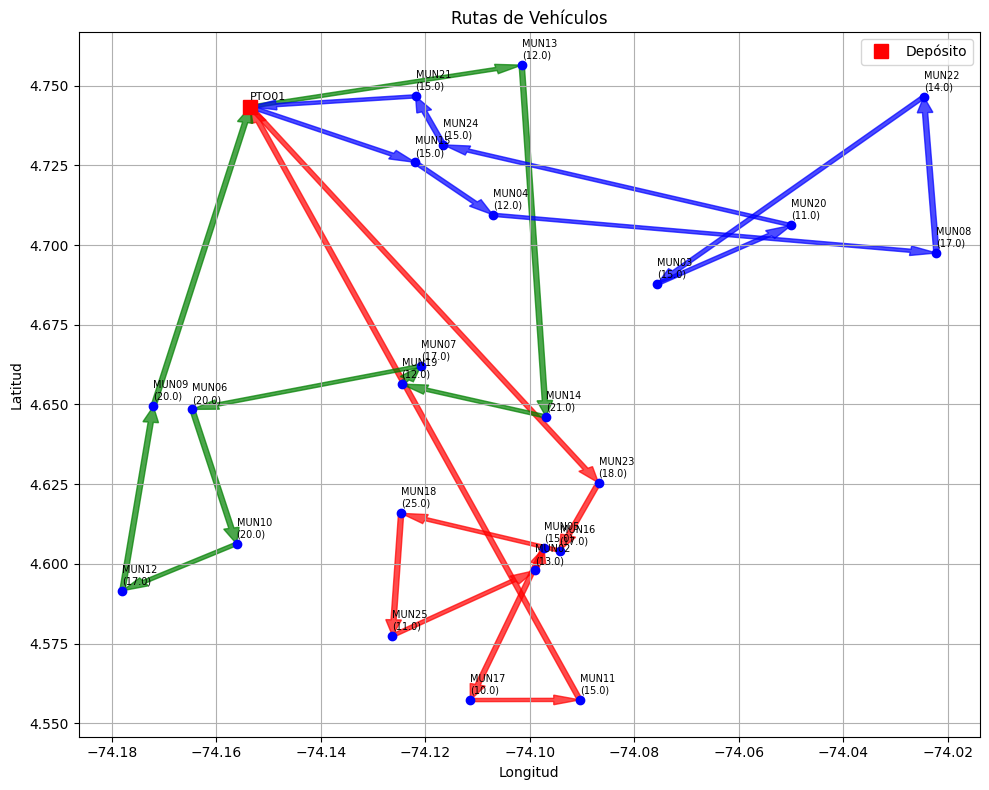

In [4]:
import pandas as pd
from pyomo.environ import *
import matplotlib.pyplot as plt
import networkx as nx
from math import radians, sin, cos, sqrt, atan2

# === 1. Cargar datos ===
clients_df = pd.read_csv('Datos/clients.csv')
depots_df = pd.read_csv('Datos/depots.csv')
vehicles_df = pd.read_csv('Datos/vehicles.csv')

# Conjuntos
D = ['MUN' + str(int(i)).zfill(2) for i in clients_df['LocationID']]
P = ['PTO' + str(int(i)).zfill(2) for i in depots_df['LocationID']]
V_set = list(vehicles_df['VehicleID'].astype(str))
N = P + D

# === Coordenadas ===
coords = {}

# Depot
for _, row in depots_df.iterrows():
    key = 'PTO' + str(int(row['LocationID'])).zfill(2)
    lat = float(row['Latitude'])
    lon = float(row['Longitude'])
    coords[key] = (lat, lon)
    print(f"[DEPOT] {key}: ({lat}, {lon})")

# Clientes
for _, row in clients_df.iterrows():
    key = 'MUN' + str(int(row['LocationID'])).zfill(2)
    lat = float(row['Latitude'])
    lon = float(row['Longitude'])
    coords[key] = (lat, lon)
    print(f"[CLIENT] {key}: ({lat}, {lon})")


# === 2. Calcular distancias (Haversine) ===
def haversine(coord1, coord2):
    R = 6371  # km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

dist = {}
for i in N:
    for j in N:
        if i != j:
            dist[(i, j)] = haversine(coords[i], coords[j])
            print(f"Distancia {i} -> {j}: {dist[(i, j)]:.2f} km")

# === Parámetros ===
Ft = 5000    # Tarifa flete COP/km
Cm = 700     # Mantenimiento COP/km

# Capacidad y autonomía
Q = dict(zip(vehicles_df['VehicleID'].astype(str), vehicles_df['Capacity']))
Autonomy = dict(zip(vehicles_df['VehicleID'].astype(str), vehicles_df['Range']))

# Demanda
demand = {}
for _, row in clients_df.iterrows():
    key = 'MUN' + str(int(row['LocationID'])).zfill(2)
    demand[key] = row['Demand']

# Calcular demanda total para verificación
total_demand = sum(demand.values())
total_capacity = sum(Q.values())
print(f"\nDemanda total: {total_demand}")
print(f"Capacidad total de vehículos: {total_capacity}")

# === 3. Modelo Pyomo ===
model = ConcreteModel()

# Sets
model.V = Set(initialize=V_set)
model.N = Set(initialize=N)
model.D = Set(initialize=D)
model.P = Set(initialize=P)

# Variables
model.x = Var(model.V, model.N, model.N, domain=Binary)
model.y = Var(model.V, domain=Binary)  # Indica si se usa el vehículo v
model.u = Var(model.V, model.N, bounds=(0, len(D)), domain=NonNegativeReals)  # Variable MTZ
model.q = Var(model.V, model.D, domain=NonNegativeReals)  # Cantidad entregada a cada cliente

# === 4. Función objetivo ===
def total_cost_rule(m):
    return sum(
        (Ft * dist[i, j] + Cm * dist[i, j]) * m.x[v, i, j]
        for v in m.V for i in m.N for j in m.N if i != j
    )
model.TotalCost = Objective(rule=total_cost_rule, sense=minimize)

# === 5. Restricciones ===

# (R1) Cada cliente es visitado exactamente una vez
def client_visited_once_rule(m, j):
    return sum(m.x[v, i, j] for v in m.V for i in m.N if i != j) == 1
model.ClientVisitedOnce = Constraint(model.D, rule=client_visited_once_rule)

# (R2) Conservación de flujo
def flow_conservation_rule(m, v, k):
    return sum(m.x[v, i, k] for i in m.N if i != k) == sum(m.x[v, k, j] for j in m.N if j != k)
model.FlowConservation = Constraint(model.V, model.N, rule=flow_conservation_rule)

# (R3) El vehículo v solo puede salir del depósito si se usa
def use_vehicle_rule(m, v):
    return sum(m.x[v, i, j] for i in m.P for j in m.N if i != j) == m.y[v]
model.UseVehicle = Constraint(model.V, rule=use_vehicle_rule)

# (R4) Capacidad del vehículo
def capacity_rule(m, v):
    return sum(demand[j] * sum(m.x[v, i, j] for i in m.N if i != j) for j in m.D) <= Q[v] * m.y[v]
model.Capacity = Constraint(model.V, rule=capacity_rule)

# (R5) Autonomía del vehículo
def autonomy_rule(m, v):
    return sum(dist[i, j] * m.x[v, i, j] for i in m.N for j in m.N if i != j) <= Autonomy[v] * m.y[v]
model.Autonomy = Constraint(model.V, rule=autonomy_rule)

# (R6) Los vehículos utilizados deben regresar al depósito
def return_to_depot_rule(m, v):
    return sum(m.x[v, i, j] for i in m.N for j in m.P if i != j) == m.y[v]
model.ReturnToDepot = Constraint(model.V, rule=return_to_depot_rule)

# (R7) Eliminación de subtours (restricciones MTZ)
def mtz_rule(m, v, i, j):
    if i in m.D and j in m.D and i != j:
        return m.u[v, j] >= m.u[v, i] + 1 - len(m.D) * (1 - m.x[v, i, j])
    else:
        return Constraint.Skip
model.MTZ = Constraint(model.V, model.N, model.N, rule=mtz_rule)

# (R8) Solo puede visitar clientes si el vehículo está en uso
def valid_route_rule(m, v, i, j):
    if i != j:
        return m.x[v, i, j] <= m.y[v]
    else:
        return Constraint.Skip
model.ValidRoute = Constraint(model.V, model.N, model.N, rule=valid_route_rule)

# === Resolver ===
solver = SolverFactory('glpk', executable='glpk-4.65\\w64\\glpsol.exe')
results = solver.solve(model, tee=True, options={'tmlim': 600})  # tiempo límite de 10 minutos

# === Mostrar resultados ===
if results.solver.status == SolverStatus.ok:
    print("\n¡Solución encontrada!")
    total_cost = value(model.TotalCost)
    print(f"Costo total: ${total_cost:.2f} COP")
    
    # Vehículos utilizados
    used_vehicles = [v for v in model.V if value(model.y[v]) > 0.5]
    print(f"\nVehículos utilizados: {len(used_vehicles)} de {len(V_set)}")
    
    # Para cada vehículo utilizado, mostrar su ruta
    for v in used_vehicles:
        route = []
        current = None
        
        # Encuentra el depósito de inicio
        for i in P:
            for j in model.N:
                if i != j and value(model.x[v, i, j]) > 0.5:
                    route.append(i)
                    current = j
                    break
            if current:
                break
                
        # Recorrer la ruta completa
        while current not in P:
            route.append(current)
            for j in model.N:
                if current != j and value(model.x[v, current, j]) > 0.5:
                    current = j
                    break
            
        route.append(current)  # Añadir el retorno al depósito
        
        # Calcular distancia y carga
        total_distance = sum(dist[route[i], route[i+1]] for i in range(len(route)-1))
        total_load = sum(demand.get(node, 0) for node in route if node in D)
        
        print(f"\nRuta del vehículo {v} (Capacidad: {Q[v]}, Autonomía: {Autonomy[v]} km):")
        print(" -> ".join(route))
        print(f"Distancia total: {total_distance:.2f} km")
        print(f"Carga total: {total_load} unidades")
        
        # Mostrar clientes visitados
        print("Clientes atendidos:")
        for node in route:
            if node in D:
                print(f"  {node}: {demand[node]} unidades")

    # Verificar que todos los clientes han sido atendidos
    all_visited = set()
    for v in used_vehicles:
        for i in model.N:
            for j in D:
                if i != j and value(model.x[v, i, j]) > 0.5:
                    all_visited.add(j)
    
    print(f"\nClientes atendidos: {len(all_visited)} de {len(D)}")
    if len(all_visited) == len(D):
        print("✅ Todos los clientes han sido atendidos.")
    else:
        print("❌ No todos los clientes han sido atendidos.")
        print("Clientes sin atender:", set(D) - all_visited)
        
    # Visualización de las rutas
    plt.figure(figsize=(10, 8))
    
    # Graficar depósitos y clientes
    for node, (lat, lon) in coords.items():
        if node in P:
            plt.plot(lon, lat, 'rs', markersize=10, label='Depósito' if node == P[0] else "")
            plt.text(lon, lat+0.002, node, fontsize=8)
        else:
            plt.plot(lon, lat, 'bo', markersize=6)
            plt.text(lon, lat+0.002, f"{node}\n({demand[node]})", fontsize=7)
    
    # Colores para las rutas
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    
    # Graficar rutas
    for idx, v in enumerate(used_vehicles):
        color = colors[idx % len(colors)]
        route_coords = []
        
        for i in model.N:
            for j in model.N:
                if i != j and value(model.x[v, i, j]) > 0.5:
                    lon_i, lat_i = coords[i][1], coords[i][0]
                    lon_j, lat_j = coords[j][1], coords[j][0]
                    plt.arrow(lon_i, lat_i, lon_j-lon_i, lat_j-lat_i, 
                              head_width=0.003, head_length=0.005, fc=color, ec=color, 
                              length_includes_head=True, alpha=0.7)
    
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Rutas de Vehículos')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('rutas_vehiculos.png')
    plt.show()
    
else:
    print("No se encontró una solución factible.")

In [5]:
# === Generar archivo de verificación ===

verif_data = []

for v in used_vehicles:
    route = []
    current = None

    # Encuentra la ruta completa
    for i in P:
        for j in model.N:
            if i != j and value(model.x[v, i, j]) > 0.5:
                route.append(i)
                current = j
                break
        if current:
            break

    while current not in P:
        route.append(current)
        for j in model.N:
            if current != j and value(model.x[v, current, j]) > 0.5:
                current = j
                break
    route.append(current)  # Cierra en depósito

    # Datos básicos
    veh_number = int(v.replace('VEH', ''))  # EXTRAEMOS el número
    vehicle_id = f"CAM{veh_number:03d}"     # Ahora sí CAM001, CAM002, etc.
    load_cap = Q[v]
    fuel_cap = Autonomy[v]
    route_sequence = " -".join(route)
    municipalities = sum(1 for node in route if node in D)
    demand_satisfied = sum(demand.get(node, 0) for node in route if node in D)
    initial_load = load_cap
    initial_fuel = fuel_cap
    total_distance = sum(dist[route[i], route[i+1]] for i in range(len(route)-1))
    total_time = total_distance * 0.87  # ejemplo: factor para convertir a tiempo aprox
    total_vehicle_cost = sum(
        (Ft * dist[route[i], route[i+1]] + Cm * dist[route[i], route[i+1]])
        for i in range(len(route)-1)
    )

    # Registro para el DataFrame
    verif_data.append({
        'VehicleId': vehicle_id,
        'LoadCap': load_cap,
        'FuelCap': fuel_cap,
        'RouteSequence': route_sequence,
        'Municipalities': municipalities,
        'DemandSatisfied': demand_satisfied,
        'ω→ InitialLoad': initial_load,
        'InitialFuel': initial_fuel,
        'Distance': round(total_distance, 2),
        'Time': round(total_time, 2),
        'TotalCost': round(total_vehicle_cost, 2)
    })

# Crear DataFrame y exportar CSV
verif_df = pd.DataFrame(verif_data)
verif_df.to_csv('verificacion_caso1.csv', index=False, encoding='utf-8')
print("\n Archivo de verificación generado: verificacion_caso1.csv")



 Archivo de verificación generado: verificacion_caso1.csv
